# LOYALTY TEST

## DSCI 100 (107) Group Project

Raj Dhillon (17571522), Diya, Oliver

### Introduction 

The "supermarket_sales.csv" dataset created by Aung Pyae on kaggle approximately 3 years ago will be manipulated for the project. The set contains data regarding 3 different supermarket branches sales across a 3 month period. 

Supermarket are often competing with one another due to demand for food and sanitary resources. Customer loyalty is one of key ingredients in having a profitable store, thus, the goal of the project is to perform classification on sales data from branch (**A**) to predict whether a person would be a store member or not based on gender, customer satisfaction rating, and total price of invoice.

The predictors used for the K-nearest neighbour classification in the project are: 
- *Gender* : The gender of the customer (1 = female, 2 = male)
- *Rating* : The customer satisfaction rating on the overall shopping experience (scale of 1 to 10)
- *Total* : Total price of goods including *unit_price*, *quantity*, and *Tax_5%*

Variable for which class will be predicted is: 
- *Customer_type* : Type of customer, either a member or not (recorded as 'member' for members and 'normal' for non-members)

Other variables from the dataset are not used as predictors since they display insignificant data with respect to classification. *Invoice ID*, *Branch*, *City*, *Date*, and *Time* are insignificant since they only help identify where the purchase was made and when. *unit_price*, *quantity* and *Tax_5%* variables are not displayed either since they are included in *total* which is an predictor. 

Through the following process, the predictors will be used to classify any customer either as a member or not a member (normal).

## Method and Reasoning for Classification with K-Nearest Neighbours

**What is classifcation with K-nearest neighbours**

Label of a new observation could be predicted with KNN-Classification. This form of classification finds the nearest or most similar observations to the new label in the training set and then predicts the label's class. The K in the classification represents the number of neighbours closest to the new observation and it is commonly chosen in advance. 

**Why is classifcation with K-nearest neighbours chosen over KNNR (K-nearest neighbour regression)**

There are two different tools that exist for statistical problems and they both utilize K-nearest neighbours (KNN). KNN is used for both classification and regression, with the difference between the two being related to how the output is calculated. KNN classification calculates it's output in a qualitative manner, however, KNN regression calculates the output in a quantitative form. Given that KNN classification calculates qualitatively, it would be appropriate to use classification since the project focuses on predicting a class not a numerical value. 

### Classification Procedure

**Importing Libraries** 

The data is read into R witht the addition of various libraries. The tidyverse package is included since it contains critical functions for loading, wrangling and visualizing data. **REPR MEANING**. Tidymodels is included since it has tools for making and using models. Tidymodels is able to maintain the code to be simple, readble, and accurate. **DPLYR MEANING**. The stringr package is added since it is required in a step later on which involves converting 'spaces' between variables to 'underscores(_)'. 

In [59]:
#library() is used to load packages into R (tidyverse), (repr), (tidymodels), (dplyr), (stringr)

library(tidyverse)
library(repr)
library(tidymodels)
library(dplyr)
if (!require("stringr")) install.packages("stringr")
library('stringr')
library(RColorBrewer)

**reading the Data into R from the web** 

The data is read directly from the web since it is stored in the group GitHub repository. The data is read by the 'read_csv' which is from the tidyverse library. 

In [60]:
#The dataset is referred to supermarket 

supermarket <- read_csv('supermarket_sales.csv')

Parsed with column specification:
cols(
  `Invoice ID` = col_character(),
  Branch = col_character(),
  City = col_character(),
  `Customer type` = col_character(),
  Gender = col_character(),
  `Product line` = col_character(),
  `Unit price` = col_double(),
  Quantity = col_double(),
  `Tax 5%` = col_double(),
  Total = col_double(),
  Date = col_character(),
  Time = col_time(format = ""),
  Payment = col_character(),
  cogs = col_double(),
  `gross margin percentage` = col_double(),
  `gross income` = col_double(),
  Rating = col_double()
)



**Converting spaces ( ) into underscores (_)** 

Following being read, the 'str_replace_all' function is used from the stringr library since it is able to convert the spaces between dataset variables to underscores. Spaces are converted to underscores to help R recognize the variables in the set. 

In [61]:
# all of the variable names are converted to have underscores rather than spaces

names(supermarket) <- str_replace_all(names(supermarket), " ", "_")

**Tidying and selecting revelant variables** 

Prior to selecting all of the relevant variables, the mutate function from tidyverse is used to convert *Customer_type* to a categorical term. It is converted by the use of the **as_factor** tool to create two different categories for future classification prediction.  *Gender* is also converted from a factor to a numerical value with the **as_numerical** tool to make it a readable predictor in KNN classification.



In [62]:
supermarket_sales <- supermarket%>%
    mutate(Customer_type = as_factor(Customer_type), Gender = as.numeric(as_factor(Gender)))
supermarket_sales_select <- supermarket_sales%>%
                            select(Gender, Total, Rating, Customer_type, Branch) %>%
                            filter(Branch == 'A')
head(supermarket_sales_select, 5)

Gender,Total,Rating,Customer_type,Branch
<dbl>,<dbl>,<dbl>,<fct>,<chr>
1,548.9715,9.1,Member,A
2,340.5255,7.4,Normal,A
2,489.0480,8.4,Member,A
2,634.3785,5.3,Normal,A
1,433.6920,5.8,Member,A


Table 1: *first 5 rows of the data with relevant predictors: Gender, Total, and Rating*

## Exploration and Visualization to find the best **K**

**Splitting the data into training and testing sets with the addition of the seed**

The first step of KNN classification requires splitting of the data into two distinct sets: a training and testing set. The training set is first used to build an accurate predicting algorithm while the testing set is used for predictive purposes. Seed for the project has been added and its works on ensuring that all numerical values are reproducible throughout.

In [63]:
# Randomly seperating the dataset into 70% training set and 30% testing set 
# Customer_type set as the response variable

set.seed(1)
supermarket_split <- initial_split(supermarket_sales_select, prop = 0.70, strata = Customer_type) 
supermarket_train <- training(supermarket_split)
supermarket_test <- testing(supermarket_split)

## **QUESTION** WHERE TO ADD 

In [64]:
supermarket_data_train <- supermarket_train%>%
    filter(Branch == 'A')%>%
    select(Customer_type, Gender, Total, Rating)

supermarket_data_train %>%
    head(5)

Customer_type,Gender,Total,Rating
<fct>,<dbl>,<dbl>,<dbl>
Member,1,548.9715,9.1
Normal,2,634.3785,5.3
Member,1,433.6920,5.8
Member,1,76.1460,7.2
Normal,1,246.4875,7.1


### Production of KNN Classification Model

**Creating the recipe** 

A recipe is created for the training set by the **recipe()** function from tidyverse. The recipe displays *Customer_type* to be the response variable to the chosen predictors. Due to the numerical distance between the variables, all values are scaled and centered.

In [65]:
supermarket_recipe <- recipe(Customer_type ~ Gender + Total + Rating , data = supermarket_train) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

**Creating validation and training sets from training data**

**vfold_cv()** function from tidyverse is used to optimize the K value. The function seperated the training data into 5 v folds containing both a training and validation set. Function also ensures correct proportions of each predictor in each fold. 

In [66]:
# seperating the training set into 5 v folds

supermarket_vfold <- vfold_cv(supermarket_train, v = 5, strata = Customer_type)

**Creating a tuned classification model**

A tuned model for KNN classification is made with no specific number of K. The **tune()** function instead will create a model displaying various K values with their respected accuracies.

In [67]:
# creation of a tuned KNN classification model 

knn_spec <- nearest_neighbor(weight_func = 'rectangular', neighbors = tune()) %>%
       set_engine("kknn") %>%
       set_mode("classification")

**fitting detail into a workflow** 

All of the products from above are put to use by the **workflow()** function from tidyverse. Workflow is able to speed the process by removing the need for minor functions such as prep() and bake(). Workflow applies the classifier to the scaled and centered folds with *K* ranging from **WHAT NUMBERS**

In [68]:
# calculating the accuracy of various K values

supermarket_workflow <- workflow()%>%
     add_recipe(supermarket_recipe) %>%
     add_model(knn_spec) %>%
     tune_grid(resamples = supermarket_vfold, grid = 10)%>%
     collect_metrics()


supermarket_workflow %>%
slice(1:5)

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.5397308,5,0.01044017,Model01
2,roc_auc,binary,0.5316232,5,0.01217544,Model01
4,accuracy,binary,0.5310465,5,0.01620680,Model02
4,roc_auc,binary,0.5694130,5,0.02403793,Model02
5,accuracy,binary,0.5186279,5,0.02973307,Model03


Table 2: *Summary of the workflow's accuracy associated with different number of neighbours (sliced tibble to decrease visual noise)*

**Visualization of the best K**

To create an optimized model with the best k value, a visualization needs to be made displaying the relationship between different number of neighbours and accuracies associated with them.

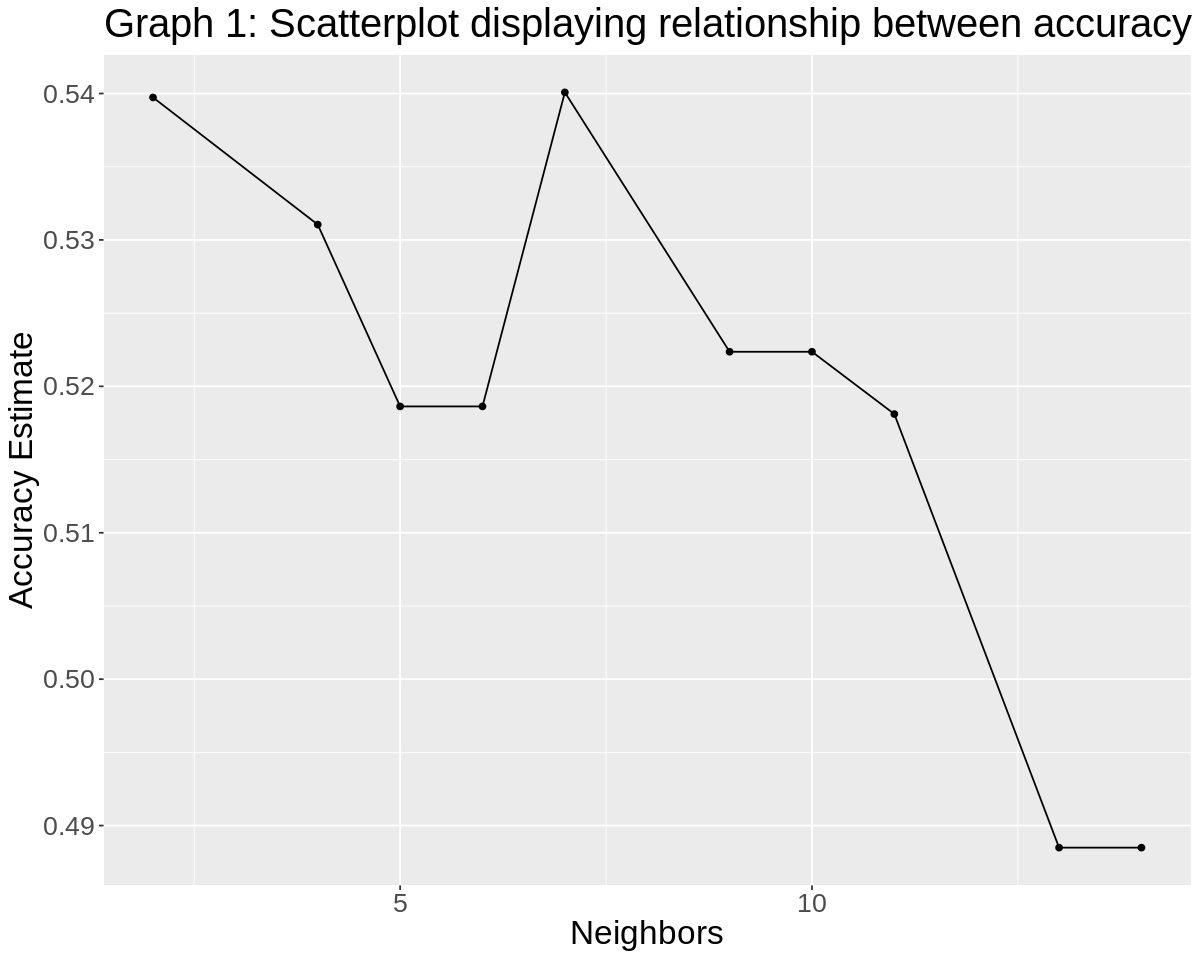

In [69]:
# filter() function removes the roc_auc from the .mectric variable
# ggplot() is used to create a visualization of neighbours vs. accuracy

supermarket_accuracies <- supermarket_workflow%>%
    filter(.metric == 'accuracy')
 
options(repr.plot.width = 10, repr.plot.height = 8)

cross_val_plot <- ggplot(supermarket_accuracies, aes(x = neighbors, y = mean)) +
    geom_point()+
    geom_line()+
    labs(x = 'Neighbors', y = 'Accuracy Estimate') + 
    ggtitle("Graph 1: Scatterplot displaying relationship between accuracy and number of neighbours") +
    theme (text = element_text (size = 20))
cross_val_plot

## Creating an Optimized Model with Best K Value '2'

addition of the K 

In [70]:
supermarket_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 2)%>% 
    set_engine('kknn') %>%
    set_mode('classification')

supermarket_fit <- supermarket_workflow <- workflow()%>%
     add_recipe(supermarket_recipe) %>%
     add_model(supermarket_spec) %>%
     fit(data = supermarket_train)

In [71]:
supermarket_predictions <- predict(supermarket_fit, supermarket_test)%>%
    bind_cols(supermarket_test)
supermarket_predictions%>%
    slice(1:5)

supermarket_metrics <- supermarket_predictions%>%
    metrics(truth = Customer_type, estimate = .pred_class)
supermarket_metrics

.pred_class,Gender,Total,Rating,Customer_type,Branch
<fct>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
Member,2,340.5255,7.4,Normal,A
Normal,2,489.0480,8.4,Member,A
Member,1,441.7560,8.5,Member,A
Normal,2,752.6400,6.6,Normal,A
Member,1,19.2465,4.3,Member,A


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.504950495
kap,binary,0.009026688


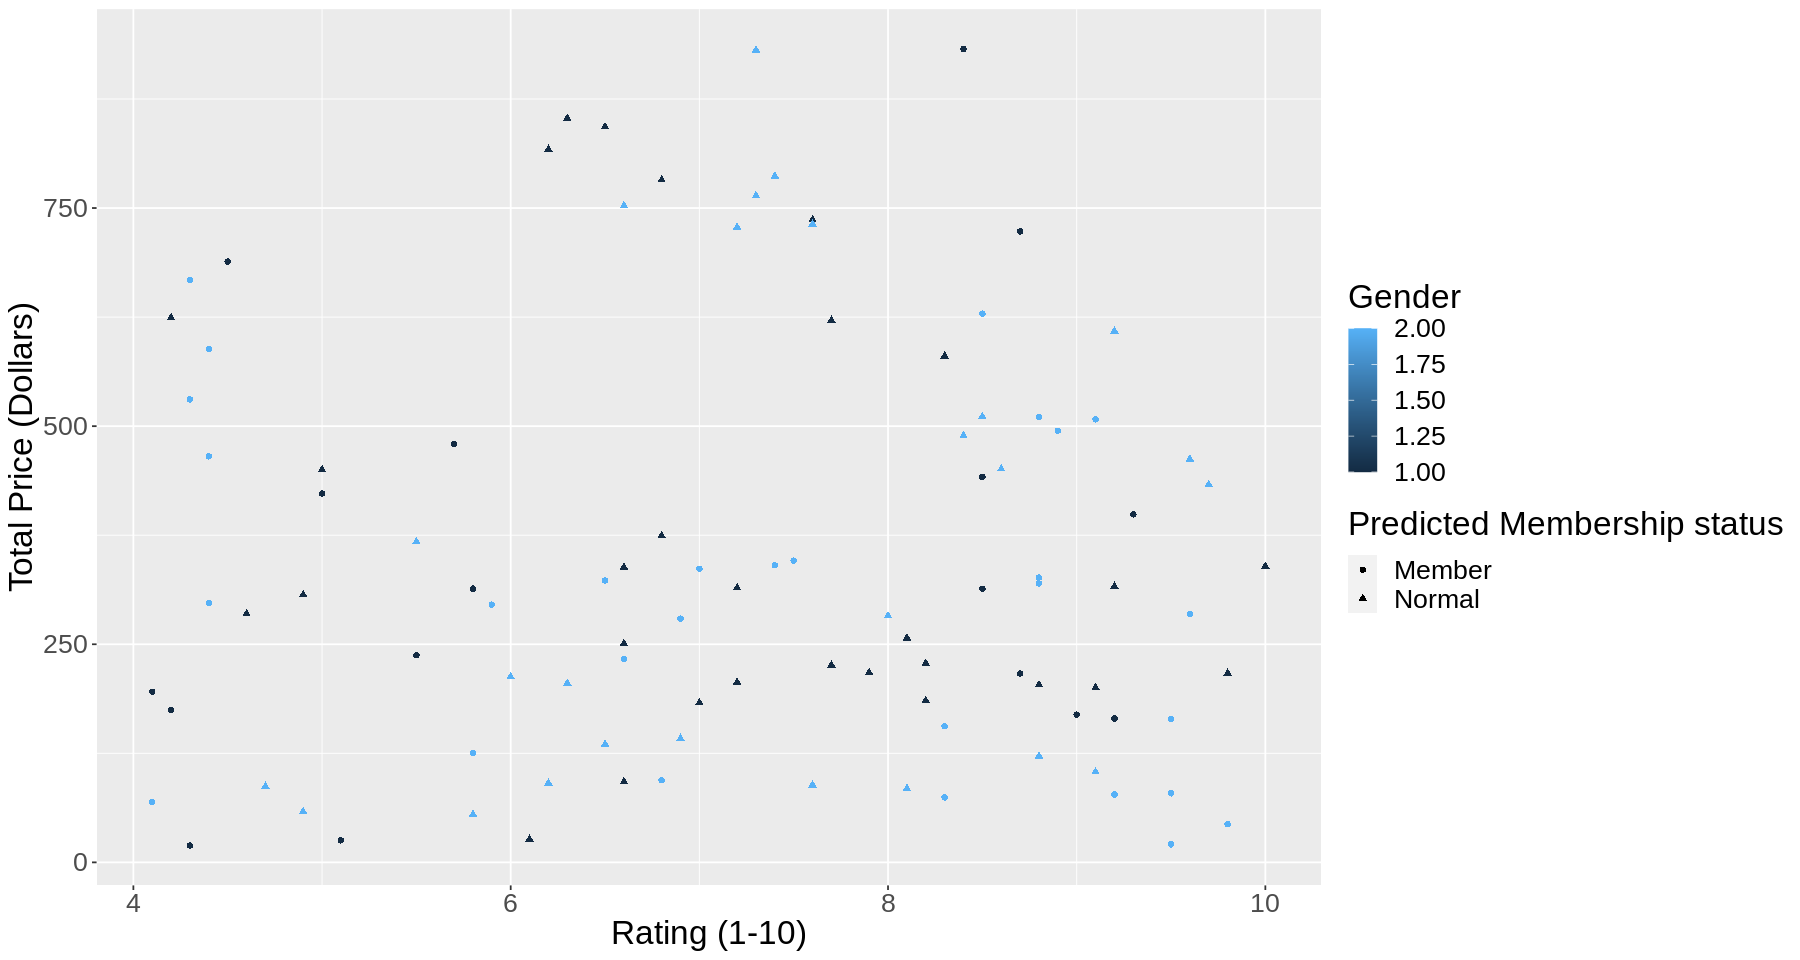

In [72]:
options(repr.plot.width = 15, repr.plot.height = 8)

supermarket_plot <- ggplot(supermarket_predictions, aes(x = Rating, y = Total, color = Gender, shape = .pred_class)) +
                    geom_point() +
                    labs(x = "Rating (1-10)", y = "Total Price (Dollars)", color = "Gender", shape = "Predicted Membership status") +
                    theme(text = element_text(size = 20))                   
supermarket_plot